<a href="https://colab.research.google.com/github/Jaimemorillo/electoral-prediction-madrid/blob/main/comunidades_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pip install python-igraph

In [ ]:
pip install leidenalg

     |████████████████████████████████| 1.4MB 2.6MB/s 


In [ ]:
pip install stylecloud

     |████████████████████████████████| 266kB 3.0MB/s 
     |████████████████████████████████| 163kB 17.2MB/s 
     |████████████████████████████████| 92kB 7.7MB/s 
     |████████████████████████████████| 92kB 7.7MB/s 
  Created wheel for stylecloud: filename=stylecloud-0.5.2-cp37-none-any.whl size=259508 sha256=882e65737e94fb48ecd2bbc510b4654a8485d0d68057fed871c2ad3e6cee55f2
  Stored in directory: /root/.cache/pip/wheels/38/60/5b/873661dde845e3b34bc73d7552f21989ebdf7c735e924dc9dd
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=a9e9b0eda6d6ca917a699ff24287363893f30d1e20f51491b15e844df33efcfa
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
  Created wheel for tinycss: filename=tinycss-0.4-cp37-none-any.whl size=43942 sha256=1c32e2d50110920359e7edabc11ca53df40d2014b393bb25e3f83590c3224e4e
  Stored in directory: /root/.cache/pip/wheels/1b/26/08/7390b2e6d5eb3403ef35647f09576459ca567d00ac725307d

In [ ]:
pip install cdlib

     |████████████████████████████████| 153kB 3.1MB/s 
     |████████████████████████████████| 40.6MB 100kB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 1.8MB 20.1MB/s 
     |████████████████████████████████| 23.9MB 2.3MB/s 
  Created wheel for karateclub: filename=karateclub-1.1.0-cp37-none-any.whl size=94228 sha256=e901add0785b55d6609581b31ba6f05adb6e8367f6ea4fe0ddc4beffbf6e5cca
  Stored in directory: /root/.cache/pip/wheels/e4/7f/b9/cb6bd89572be748b7ba620970fbd5e19d5729e01b07bc05686
  Created wheel for python-louvain: filename=python_louvain-0.14-cp37-none-any.whl size=9292 sha256=5788001c485005511a147a1619386f58da6421e463eecb1d25044d7065fe4042
  Stored in directory: /root/.cache/pip/wheels/e7/8d/24/6b3a464bb23e96ecba3f68868e85721534fd8158a9cd7b426b
Successfully built karateclub python-louvain
  Found existing installation: python-louvain 0.15
    Uninstalling python-louvain-0.15:
      Successfully uninstalled python-louvain-0.15


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_theme()
sns.set_context("notebook")
import community
import igraph as ig
import leidenalg as la
from cdlib import algorithms
import networkx.algorithms.community as nx_comm

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Leemos los datos

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Tweets_elecciones/resultados_TFG_complete_1.csv', 
                 sep='~', encoding='utf-8', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,6,7,11,23,25,29,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df['user_id'] = pd.to_numeric(df['user_id'], errors='coerce')
df = df.dropna(subset=['user_id'])
df['user_id'] = df['user_id'].astype(int)

df['followers_count'] = pd.to_numeric(df['followers_count'], errors='coerce')

In [ ]:
df['created_at'] = df['created_at'].apply(lambda x: x[0:10])
df['account_created_at'] = df['account_created_at'].apply(lambda x: str(x)[0:10] if str(x)!='nan' else x)
df = df[df['created_at'].str.startswith('2021')]

In [ ]:
def string_as_array(x):
  if x is not np.nan:
    return str(x).split(",")
  else:
    return np.nan

In [ ]:
df.mentions_user_id = df.mentions_user_id.apply(lambda x: string_as_array(x))
df.mentions_screen_name = df.mentions_screen_name.apply(lambda x: string_as_array(x))
df.hashtags = df.hashtags.apply(lambda x: string_as_array(x))

In [ ]:
# Calculamos las aristas y los nodos
df_temp = df[['screen_name','retweet_screen_name']]
df_temp = df_temp[df_temp['screen_name']!=df_temp['retweet_screen_name']]
df_edge_list = df_temp.copy()
df_edge_list = df_edge_list.groupby(['screen_name', 'retweet_screen_name'], as_index=False).size().rename(columns={'size': 'weight'})
nodes_no_conection = df_temp[pd.isnull(df_temp['retweet_screen_name'])] # ¿Qué hacemos con los tweets aislados?
df_edge_list['width'] = df_edge_list['weight']

#df_edge_list = df_edge_list.sample(2000, random_state=9)
#df_edge_list = df_edge_list.head(20000)

nodes_size = df_edge_list.groupby('retweet_screen_name', as_index=False).size()
nodes_size['size'] = MinMaxScaler(feature_range=(5,50)).fit_transform(nodes_size['size'].values.reshape(-1,1))

#df_edge_list = df_edge_list.join(nodes.set_index('retweet_screen_name'), on='retweet_screen_name')
#df_edge_list = df_edge_list.sort_values('size', ascending=False)

In [ ]:
#Calculamos atributos de los nodos
df_temp1 = df[['screen_name','statuses_count','followers_count','friends_count',
               'created_at','favourites_count','account_created_at']]
df_temp2 = df[['retweet_screen_name','retweet_statuses_count',
               'retweet_followers_count','retweet_friends_count','created_at']]
df_temp2['favourites_count'] = np.nan
df_temp2['account_created_at'] = np.nan
df_temp2.columns = df_temp1.columns
df_temp = df_temp2.append(df_temp1).reset_index(drop=True).dropna(subset=['screen_name'])
df_temp = df_temp.dropna(subset=['followers_count'])
nodes = df_temp.drop_duplicates(subset=['screen_name'], keep='last').reset_index(drop=True)
nodes['days_old'] = (pd.to_datetime(nodes['created_at']) - pd.to_datetime(nodes['account_created_at'])).dt.days

nodes['statuses_count'] = nodes['statuses_count'].astype(int)
nodes['followers_count'] = nodes['followers_count'].astype(int)
nodes['friends_count'] = nodes['friends_count'].astype(int)
nodes['favourites_count'] = nodes['favourites_count'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
G = nx.from_pandas_edgelist(df_edge_list, 
                            source='retweet_screen_name',
                            target='screen_name',
                            #edge_attr=['weight','width'],
                            create_using=nx.DiGraph())

nx.set_node_attributes(G, pd.Series(nodes_size.set_index('retweet_screen_name')['size']).to_dict(), 'size')
nx.set_node_attributes(G, pd.Series(nodes.set_index('screen_name')['statuses_count']).to_dict(), 'statuses_count')
nx.set_node_attributes(G, pd.Series(nodes.set_index('screen_name')['followers_count']).to_dict(), 'followers_count')
nx.set_node_attributes(G, pd.Series(nodes.set_index('screen_name')['friends_count']).to_dict(), 'friends_count')
nx.set_node_attributes(G, pd.Series(nodes.set_index('screen_name')['favourites_count']).to_dict(), 'favourites_count')
nx.set_node_attributes(G, pd.Series(nodes.set_index('screen_name')['days_old']).to_dict(), 'days_old')
# networkx.DiGraph.reverse()

In [ ]:
vertex_df_ini = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

tuples = [tuple(x) for x in df_edge_list[['retweet_screen_name','screen_name']].values]
g = ig.Graph.TupleList(tuples, directed = True)

vertex_df_ini = g.get_vertex_dataframe().join(vertex_df_ini, on='name')
g.vs["statuses_count"] = vertex_df_ini.statuses_count.values
g.vs["followers_count"] = vertex_df_ini.followers_count.values
g.vs["friends_count"] = vertex_df_ini.friends_count.values
g.vs["favourites_count"] = vertex_df_ini.favourites_count.values
g.vs["days_old"] = vertex_df_ini.days_old.values

# Comunidades

https://cdlib.readthedocs.io/en/latest/index.html

In [ ]:
vertex_df = g.get_vertex_dataframe()
vertex_df['degree'] = g.degree()
vertex_df['out_degree'] = g.outdegree()
vertex_df['in_degree'] = g.indegree()

In [ ]:
names_to_keep = ['PabloIglesias', 'PODEMOS', 'agarzon', 'laSextaTV', 'IzquierdaUnida', 'PabloEchenique',
                 'elmundoes', 'A3Noticias', 'Albert_Rivera', 'populares', 'pablocasado_', 'IdiazAyuso', 'Tonicanto1',
                 'Santi_ABASCAL', 'vox_es', 'ivanedlm', 'monasterioR',
                 'el_pais', 'sanchezcastejon', 'equipoGabilondo', 'rtve', 'PSOE', 'informativost5',
                 'InesArrimadas', 'CiudadanosCs', 'begonavillacis', 'BalEdmundo']

vertex_df['name_2'] = vertex_df['name'].apply(lambda x: x if x in names_to_keep else '')

nx.set_node_attributes(G, vertex_df.set_index('name')['name_2'].to_dict(), 'name_2')

In [ ]:
def dendrogram(community):
  """
  Returns a list of lists where each sublist is a community
  Returns: list(list())
  """
  values = set(list(community.values()))
  dendrogram = []
  for com in values:
    dendrogram.append([key for key,value in community.items() if value == com])
  return dendrogram

## Louvain

In [ ]:
G_un = G.to_undirected()

In [ ]:
partition = community.best_partition(G_un, random_state=9)

In [ ]:
max(partition.values()) + 1

782

In [ ]:
vertex_df = vertex_df.join(pd.Series(partition).rename('community_lou'), on='name')
nx.set_node_attributes(G, partition, 'community_lou')

In [ ]:
vertex_df.community_lou.value_counts(normalize=True).head(8)

0    0.286036
1    0.264438
6    0.091996
2    0.087046
4    0.065652
5    0.048405
3    0.035058
9    0.022106
Name: community_lou, dtype: float64

In [ ]:
vertex_df.community_lou.value_counts(normalize=True).head(8).sum()

0.9007368730363238

In [ ]:
nx_comm.modularity(G, dendrogram(partition))

0.6018494262086058

In [ ]:
keys = vertex_df.community_lou.value_counts(normalize=True).head(8).keys().to_list()
nodes_to_delete = vertex_df[~vertex_df['community_lou'].isin(keys)].name.values
G.remove_nodes_from(nodes_to_delete)

In [ ]:
nx.is_weakly_connected(G)

True

In [ ]:
""" Write to GEXF """
# Use 1.2draft so you do not get a deprecated warning in Gelphi
nx.write_gexf(G, "louvain_2.gexf", version="1.2draft")

## Leiden





In [ ]:
partition = la.find_partition(g, la.ModularityVertexPartition, n_iterations=-1, seed=1996)

In [ ]:
partition.summary()

'Clustering with 88482 elements and 814 clusters'

In [ ]:
vertex_df['community_leid'] = partition.membership[:]
nx.set_node_attributes(G, vertex_df.set_index('name')['community_leid'].to_dict(), 'community_leid')

In [ ]:
vertex_df.community_leid.value_counts(normalize=True).head(7)

0    0.315013
1    0.215513
2    0.209715
3    0.075529
4    0.036199
5    0.029249
6    0.019993
Name: community_leid, dtype: float64

In [ ]:
vertex_df.community_leid.value_counts(normalize=True).head(7).sum()

0.9012115458511336

In [ ]:
nx_comm.modularity(G, dendrogram(vertex_df.set_index('name')['community_leid'].to_dict()))

0.6132682268665344

In [ ]:
keys = vertex_df.community_leid.value_counts(normalize=True).head(7).keys().to_list()
nodes_to_delete = vertex_df[~vertex_df['community_leid'].isin(keys)].name.values
G.remove_nodes_from(nodes_to_delete)

In [ ]:
nx.is_weakly_connected(G)

True

In [129]:
nodes_to_delete = vertex_df[~vertex_df['community_leid'].isin([0,1,2,3,6])].name.values
G.remove_nodes_from(nodes_to_delete)

In [130]:
vertex_df_f = vertex_df[vertex_df['community_leid'].isin([0,1,2,3,6])]
nx_comm.modularity(G, dendrogram(vertex_df_f.set_index('name')['community_leid'].to_dict()))

0.5738484884656815

In [ ]:
""" Write to GEXF """
# Use 1.2draft so you do not get a deprecated warning in Gelphi
nx.write_gexf(G, "leid_2.gexf", version="1.2draft")

# Analisis

In [ ]:
vertex_df[vertex_df['community_leid']==1][['name', 
                                           'followers_count']].sort_values('followers_count', 
                                                                           ascending=False).head(11).to_latex(index=False)

'\\begin{tabular}{lr}\n\\toprule\n           name &  followers\\_count \\\\\n      elmundoes &          3937484 \\\\\n\\midrule\n         abc\\_es &          2117214 \\\\\n     A3Noticias &          1985459 \\\\\n    EFEnoticias &          1909742 \\\\\n    europapress &          1401072 \\\\\n  Albert\\_Rivera &          1228455 \\\\\n    manuelvalls &          1052395 \\\\\n       CasaReal &          1045969 \\\\\n elconfidencial &           914529 \\\\\n  LucioQuincioC &           869720 \\\\\n      populares &           822216 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
vertex_df[vertex_df['community_leid']==1][['name', 
                                           'out_degree']].sort_values('out_degree', 
                                                                           ascending=False).head(11).to_latex(index=False)

'\\begin{tabular}{lr}\n\\toprule\n            name &  out\\_degree \\\\\n     pons\\_sabate &        8689 \\\\\n\\midrule\n    rosadiezglez &        4703 \\\\\n     janogarcia\\_ &        3663 \\\\\n      Tonicanto1 &        3545 \\\\\n     europapress &        1929 \\\\\n   crpandemonium &        1603 \\\\\n AntonioRNaranjo &        1599 \\\\\n  GirautaOficial &        1370 \\\\\n     cmgorriaran &        1243 \\\\\n      voz\\_populi &         841 \\\\\n  goyofermoselle &         726 \\\\\n\\bottomrule\n\\end{tabular}\n'

Nube de palabras

In [ ]:
import stylecloud
from IPython.display import Image
import palettable as pal

In [ ]:
podemos = pal.cartocolors.sequential.Purp_7.hex_colors[-4:]
pp = pal.colorbrewer.sequential.Blues_7.hex_colors[-4:]
vox = pal.colorbrewer.sequential.Greens_7.hex_colors[-4:]
psoe = pal.colorbrewer.sequential.Reds_7.hex_colors[-4:]
ciudadanos = pal.colorbrewer.sequential.Oranges_7.hex_colors[-4:]

In [ ]:
def has_to_text(x):
  try:
    return " ".join(x)
  except:
    return "NOHASH"
    
content_df = vertex_df[['name',
                        'community_leid']].join(df[['screen_name','text',
                                                    'hashtags']].set_index('screen_name'), on='name', how='left')

content_df['hashtags'] = content_df['hashtags'].apply(lambda x: has_to_text(x))
content_df['text'] = content_df['text'].astype(str)

#content_df = content_df.drop_duplicates(['name', 'text'])

In [ ]:
stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist() + ['CS', 'PP', 'VOX', 'PSOE', 'HTTPS', 'CO', 'NOHASH', 'CIUDADANOS']

In [ ]:
content_tmp = content_df[content_df['community_leid']==6]

In [ ]:
# Hastahgs
stylecloud.gen_stylecloud(text = " ".join(content_tmp.hashtags.values), icon_name= "fas fa-square",
                          colors=ciudadanos,
                          background_color='white', custom_stopwords=stop_words,
                          gradient='horizontal',
                          random_state=1996,
                          collocations=False,
                          output_name='word_cloud_has.png')

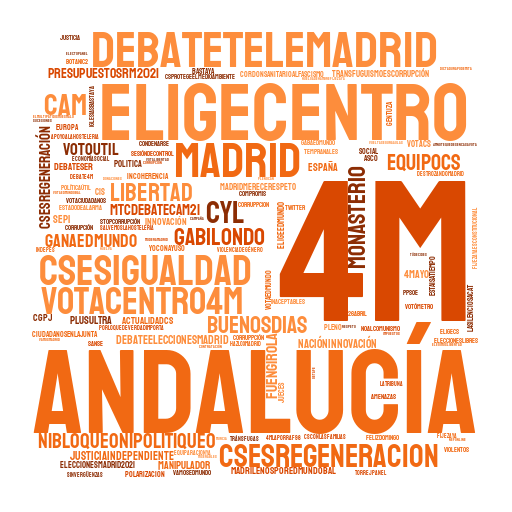

In [ ]:
Image('/content/word_cloud_has.png')

In [ ]:
# Text
stylecloud.gen_stylecloud(text = " ".join(content_tmp.text.values), icon_name= "fab fa-twitter",
                          colors=ciudadanos,
                          background_color='white', custom_stopwords=stop_words,
                          gradient='horizontal',
                          random_state=1996,
                          output_name='word_cloud_text.png')

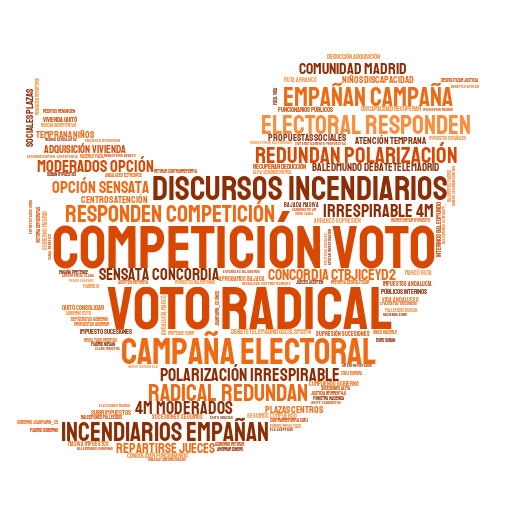

In [ ]:
Image('/content/word_cloud_text.png')

Meter todo en una tabla

Podemos

In [82]:
results_df = pd.DataFrame(columns=['party','density','followers mean','degree mean','out degree mean', 'in degree mean'])

In [83]:
party = 0
nodes_to_keep = vertex_df[vertex_df['community_leid']==party].name.values
H = G.subgraph(nodes_to_keep)

print(round(nx.density(H),8))

maean_info = vertex_df[vertex_df['community_leid']==party][['followers_count','degree',
                                           'out_degree', 'in_degree']].mean().round(2).values

results_df.loc[party, 'party'] = 'Podemos'
results_df.iloc[party, 1:] = [round(nx.density(H),8)] +  list(maean_info)                             

0.00010638


PP

In [84]:
party = 1
nodes_to_keep = vertex_df[vertex_df['community_leid']==party].name.values
H = G.subgraph(nodes_to_keep)

print(round(nx.density(H),8))

maean_info = vertex_df[vertex_df['community_leid']==party][['followers_count','degree',
                                           'out_degree', 'in_degree']].mean().round(2).values

results_df.loc[party, 'party'] = 'PP'
results_df.iloc[party, 1:] = [round(nx.density(H),8)] +  list(maean_info)   

9.751e-05


Vox

In [85]:
party = 2
nodes_to_keep = vertex_df[vertex_df['community_leid']==party].name.values
H = G.subgraph(nodes_to_keep)

print(round(nx.density(H),8))

maean_info = vertex_df[vertex_df['community_leid']==party][['followers_count','degree',
                                           'out_degree', 'in_degree']].mean().round(2).values

results_df.loc[party, 'party'] = 'Vox'
results_df.iloc[party, 1:] = [round(nx.density(H),8)] +  list(maean_info)   

0.00022071


PSOE

In [86]:
party = 3
nodes_to_keep = vertex_df[vertex_df['community_leid']==party].name.values
H = G.subgraph(nodes_to_keep)

print(round(nx.density(H),8))

maean_info = vertex_df[vertex_df['community_leid']==party][['followers_count','degree',
                                           'out_degree', 'in_degree']].mean().round(2).values

results_df.loc[party, 'party'] = 'PSOE'
results_df.iloc[party, 1:] = [round(nx.density(H),8)] +  list(maean_info)   

0.00036329


Ciudadanos

In [87]:
party = 6
nodes_to_keep = vertex_df[vertex_df['community_leid']==party].name.values
H = G.subgraph(nodes_to_keep)

print(round(nx.density(H),8))

maean_info = vertex_df[vertex_df['community_leid']==party][['followers_count','degree',
                                           'out_degree', 'in_degree']].mean().round(2).values

results_df.loc[4, 'party'] = 'Ciudadanos'
results_df.iloc[4, 1:] = [round(nx.density(H),8)] +  list(maean_info)   

0.00141643


In [91]:
results_df

,party,density,followers mean,degree mean,out degree mean,in degree mean
0,Podemos,0.00010638,2088.19,6.37,3.2,3.17
1,PP,9.751e-05,2578,5.08,2.66,2.42
2,Vox,0.00022071,1940.84,9.57,4.68,4.89
3,PSOE,0.00036329,5126.42,6.12,2.98,3.14
4,Ciudadanos,0.00141643,2454.25,5.58,2.7,2.88


## Boundary

In [135]:
vertex_df_f.community_leid.value_counts(normalize=True)

0    0.376917
1    0.257863
2    0.250926
3    0.090372
6    0.023922
Name: community_leid, dtype: float64

In [266]:
party_order = [0,3,6,1,2]

In [267]:
pol_matrix = pd.DataFrame(index=['Podemos','PSOE','Ciudadanos','PP', 'VOX'], columns=['Podemos','PSOE','Ciudadanos','PP', 'VOX'])

Podemos

In [268]:
party=0
row=0

for idx,i in enumerate(party_order):

  bunch_1 = set(vertex_df_f[vertex_df_f['community_leid']==i].name.values)
  bunch_2 = set(vertex_df_f[vertex_df_f['community_leid']==party].name.values)

  boundary_nodes = nx.node_boundary(G, bunch_1, bunch_2)

  polarity = 1 - (len(boundary_nodes)/len(bunch_2))

  if row==idx:
    pol_matrix.iloc[row,idx] = 0
  else:
    pol_matrix.iloc[row,idx] = round(polarity,2)

PSOE

In [269]:
party=3
row = 1

for idx,i in enumerate(party_order):

  bunch_1 = set(vertex_df_f[vertex_df_f['community_leid']==i].name.values)
  bunch_2 = set(vertex_df_f[vertex_df_f['community_leid']==party].name.values)

  boundary_nodes = nx.node_boundary(G, bunch_1, bunch_2)

  polarity = 1 - (len(boundary_nodes)/len(bunch_2))

  if row==idx:
    pol_matrix.iloc[row,idx] = 0
  else:
    pol_matrix.iloc[row,idx] = round(polarity,2)

Ciudanos

In [270]:
party=6
row = 2

for idx,i in enumerate(party_order):

  bunch_1 = set(vertex_df_f[vertex_df_f['community_leid']==i].name.values)
  bunch_2 = set(vertex_df_f[vertex_df_f['community_leid']==party].name.values)

  boundary_nodes = nx.node_boundary(G, bunch_1, bunch_2)

  polarity = 1 - (len(boundary_nodes)/len(bunch_2))

  if row==idx:
    pol_matrix.iloc[row,idx] = 0
  else:
    pol_matrix.iloc[row,idx] = round(polarity,2)

PP

In [271]:
party=1
row = 3

for idx,i in enumerate(party_order):

  bunch_1 = set(vertex_df_f[vertex_df_f['community_leid']==i].name.values)
  bunch_2 = set(vertex_df_f[vertex_df_f['community_leid']==party].name.values)

  boundary_nodes = nx.node_boundary(G, bunch_1, bunch_2)

  polarity = 1 - (len(boundary_nodes)/len(bunch_2))

  if row==idx:
    pol_matrix.iloc[row,idx] = 0
  else:
    pol_matrix.iloc[row,idx] = round(polarity,2)

Vox

In [272]:
party=2
row = 4

for idx,i in enumerate(party_order):

  bunch_1 = set(vertex_df_f[vertex_df_f['community_leid']==i].name.values)
  bunch_2 = set(vertex_df_f[vertex_df_f['community_leid']==party].name.values)

  boundary_nodes = nx.node_boundary(G, bunch_1, bunch_2)

  polarity = 1 - (len(boundary_nodes)/len(bunch_2))

  if row==idx:
    pol_matrix.iloc[row,idx] = 0
  else:
    pol_matrix.iloc[row,idx] = round(polarity,2)

In [273]:
pol_matrix = pol_matrix.astype(float)

Text(30.5, 0.5, 'DESDE')

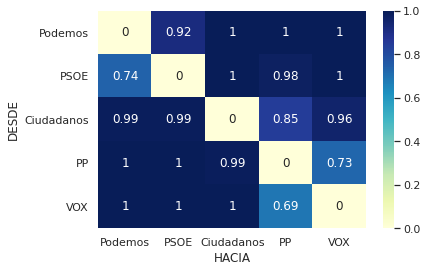

In [274]:
ax = sns.heatmap(pol_matrix, annot=True, cmap="YlGnBu")
ax.set_xlabel('HACIA')
ax.set_ylabel('DESDE')

Izquierda -> Derecha

In [275]:
bunch_1 = set(vertex_df_f[vertex_df_f['community_leid'].isin([1,2,6])].name.values)
bunch_2 = set(vertex_df_f[vertex_df_f['community_leid'].isin([0,3])].name.values)

boundary_nodes = nx.node_boundary(G, bunch_1, bunch_2)

polarity = 1 - (len(boundary_nodes)/len(bunch_2))

print(polarity)

0.9900451441139021


Derecha -> Izquierda

In [276]:
bunch_1 = set(vertex_df_f[vertex_df_f['community_leid'].isin([1,2,6])].name.values)
bunch_2 = set(vertex_df_f[vertex_df_f['community_leid'].isin([0,3])].name.values)

boundary_nodes = nx.node_boundary(G, bunch_2, bunch_1)

polarity = 1 - (len(boundary_nodes)/len(bunch_2))

print(polarity)

0.9899872670447969


## Brokerage


In [277]:
import itertools

class _RoleClassifier(object):
	roleTypes = { \
				 "coordinator"		: lambda pred,broker,succ: pred == broker == succ, \
				 "gatekeeper" 	 	: lambda pred,broker,succ: pred != broker == succ, \
				 "representative"	: lambda pred,broker,succ: pred == broker != succ, \
				 "consultant"		: lambda pred,broker,succ: pred == succ != broker, \
				 "liaison"			: lambda pred,broker,succ: pred != succ and pred != broker and broker != succ, \
				}
				
	@classmethod
	def classify(cls,predecessor_group,broker_group,successor_group):
		for role,predicate in cls.roleTypes.items():
			if predicate(predecessor_group,broker_group,successor_group):
				return role
		raise Exception("Could not classify... this should never happen")
	
def getBrokerageRoles(graph,partition):
	"""
	Counts how many times each node in graph acts as one of the five brokerage roles described by Steven Borgatti in
	http://www.analytictech.com/essex/Lectures/Brokerage.pdf
	
	graph: a networx DiGraph
	partition: a dictionary mapping node -> group, must map every node. If a node has no group associate then put it by itself in a new group
	
	returns: {node -> {"cooridnator": n, "gatekeeper": n, "representative": n, "consultant": n, "liaison": n}} where n is the number of times
	node acted as that role
	"""
	
	roleClassifier = _RoleClassifier()
	
	roles = dict((node, dict((role,0) for role in roleClassifier.roleTypes)) for node in graph)
	for node in graph:
		for successor in graph.successors(node):
			for predecessor in graph.predecessors(node):
				if successor == predecessor or successor == node or predecessor == node: continue
				if not (graph.has_edge(predecessor, successor)):
					# found a broker!
					# now which kind depends on who is in which group
					roles[node][roleClassifier.classify(partition[predecessor],partition[node],partition[successor])] += 1
	return roles

In [278]:
brok_dict = getBrokerageRoles(G, vertex_df_f.set_index('name')['community_leid'].to_dict())

In [279]:
brok_df = pd.DataFrame(brok_dict).T

In [ ]:
vertex_df_f = vertex_df_f.join(brok_df, on='name')

In [281]:
brok_df_com = pd.DataFrame(columns=['party','coordinators','gatekeepers','representatives','consultants','liaisons'])

Podemos

In [ ]:
brok_df_party = pd.DataFrame()

In [297]:
party = 0

total = len(vertex_df_f[vertex_df_f['community_leid']==party])
coordinators = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['coordinator']>0)])
gatekeepers = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['gatekeeper']>0)])
representatives = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['representative']>0)])
consultants = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['consultant']>0)])
liaisons = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['liaison']>0)])

brok_df_com.loc[party,'party'] ='Podemos'
brok_df_com.loc[party, 1:] = [round((coordinators/total)*100,2),
                              round((gatekeepers/total)*100,2),
                              round((representatives/total)*100,2),
                              round((consultants/total)*100,2),
                              round((liaisons/total)*100,2)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  from ipykernel import kernelapp as app


In [298]:
data = {'coordinators':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('coordinator', 
                                                                                 ascending=False)['name'].head(10).values,
        'gatekeepers':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('gatekeeper', 
                                                                                 ascending=False)['name'].head(10).values,
        'representatives':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('representative', 
                                                                                 ascending=False)['name'].head(10).values,
        'consultants':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('consultant', 
                                                                                 ascending=False)['name'].head(10).values,
        'liaisons':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('liaison', 
                                                                                 ascending=False)['name'].head(10).values
        }
                                                                               
pd.DataFrame(data)

,coordinators,gatekeepers,representatives,consultants,liaisons
0,tomascasascm,gmaemejota,tomascasascm,RosaVillacastin,RosaVillacastin
1,gmaemejota,RosaVillacastin,gmaemejota,gmaemejota,Alex72548885
2,h0m3r02,h0m3r02,h0m3r02,h0m3r02,gmaemejota
3,cleosagas1,tomascasascm,Zapatista72,jess_pozo,BlaancaNiieves
4,JulianMaciasT,Zapatista72,RosaVillacastin,Zapatista72,mangemalo
5,PODEMOS,judit_sinhache,quiquepeinado,mangemalo,Luis_Endera
6,Zapatista72,cleosagas1,paupaupau_pau,RLCar34,tomascasascm
7,JuanyGar63,rosamariaartal,ClauIrenita99,tomascasascm,judit_sinhache
8,quiquepeinado,jess_pozo,JulianMaciasT,rosamariaartal,maximariana2
9,paupaupau_pau,Luis_Endera,PODEMOS,judit_sinhache,anaalonsogonza1


PP

In [299]:
party = 1

total = len(vertex_df_f[vertex_df_f['community_leid']==party])
coordinators = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['coordinator']>0)])
gatekeepers = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['gatekeeper']>0)])
representatives = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['representative']>0)])
consultants = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['consultant']>0)])
liaisons = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['liaison']>0)])

brok_df_com.loc[party,'party'] ='PP'
brok_df_com.loc[party, 1:] = [round((coordinators/total)*100,2),
                              round((gatekeepers/total)*100,2),
                              round((representatives/total)*100,2),
                              round((consultants/total)*100,2),
                              round((liaisons/total)*100,2)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  from ipykernel import kernelapp as app


In [300]:
data = {'coordinators':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('coordinator', 
                                                                                 ascending=False)['name'].head(10).values,
        'gatekeepers':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('gatekeeper', 
                                                                                 ascending=False)['name'].head(10).values,
        'representatives':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('representative', 
                                                                                 ascending=False)['name'].head(10).values,
        'consultants':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('consultant', 
                                                                                 ascending=False)['name'].head(10).values,
        'liaisons':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('liaison', 
                                                                                 ascending=False)['name'].head(10).values
        }
                                                                               
pd.DataFrame(data)

,coordinators,gatekeepers,representatives,consultants,liaisons
0,pons_sabate,europapress,pons_sabate,CdV_Navarra,europapress
1,Tonicanto1,CdV_Navarra,Tonicanto1,BernaldoDQuiros,fjballest
2,populares,Proserpinasb,GirautaOficial,Proserpinasb,BelenYelmo
3,GirautaOficial,BernaldoDQuiros,europapress,ElDiestro_,melvira333
4,europapress,MoniLisa2,populares,okdiario,ALVAROAVI
5,anadebande,ElDiestro_,BernaldoDQuiros,anntonioz,PJoliCo
6,pablocasado_,BelenYelmo,CdV_Navarra,MoniLisa2,Ruben_Sardon
7,DesbloqueandoEs,MarquesUltra,anadebande,paulitatorment,soquinci
8,ppmadrid,ALVAROAVI,diegodelacruz,europapress,BernaldoDQuiros
9,MoniLisa2,anntonioz,alejandroTGN,ALVAROAVI,AnaMari97026935


Vox

In [301]:
party = 2

total = len(vertex_df_f[vertex_df_f['community_leid']==party])
coordinators = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['coordinator']>0)])
gatekeepers = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['gatekeeper']>0)])
representatives = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['representative']>0)])
consultants = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['consultant']>0)])
liaisons = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['liaison']>0)])

brok_df_com.loc[party,'party'] ='VOX'
brok_df_com.loc[party, 1:] = [round((coordinators/total)*100,2),
                              round((gatekeepers/total)*100,2),
                              round((representatives/total)*100,2),
                              round((consultants/total)*100,2),
                              round((liaisons/total)*100,2)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  from ipykernel import kernelapp as app


In [302]:
data = {'coordinators':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('coordinator', 
                                                                                 ascending=False)['name'].head(10).values,
        'gatekeepers':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('gatekeeper', 
                                                                                 ascending=False)['name'].head(10).values,
        'representatives':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('representative', 
                                                                                 ascending=False)['name'].head(10).values,
        'consultants':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('consultant', 
                                                                                 ascending=False)['name'].head(10).values,
        'liaisons':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('liaison', 
                                                                                 ascending=False)['name'].head(10).values
        }
                                                                               
pd.DataFrame(data)

,coordinators,gatekeepers,representatives,consultants,liaisons
0,budaoscar1,BECAES_,emily_habsburg,BECAES_,Motard8559
1,vox_es,gonnassau,OrbitaEduardo,gonnassau,BECAES_
2,OrbitaEduardo,vox_es,budaoscar1,libertaddigital,JorgedeArlanza
3,emily_habsburg,hermanntertsch,BECAES_,vox_es,GatoCurioso77
4,AsdeTrebolesB,jaimeberenguer,vox_es,Lola14262397,VA1099
5,BECAES_,Lola14262397,_Palas_Atenea,_Gordon_Gekko_G,vox_es
6,Victoria_186070,Motard8559,_Gordon_Gekko_G,WillyTolerdoo,CKLBAUER
7,Gimnastico84,libertaddigital,AsdeTrebolesB,mcyava,YO36663935
8,Motard8559,_Gordon_Gekko_G,gonnassau,danielortizguer,_Gordon_Gekko_G
9,contrastado,mcyava,Motard8559,jaimeberenguer,miriamdm1956


PSOE

In [303]:
party = 3

total = len(vertex_df_f[vertex_df_f['community_leid']==party])
coordinators = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['coordinator']>0)])
gatekeepers = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['gatekeeper']>0)])
representatives = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['representative']>0)])
consultants = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['consultant']>0)])
liaisons = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['liaison']>0)])

brok_df_com.loc[party,'party'] ='PSOE'
brok_df_com.loc[party, 1:] = [round((coordinators/total)*100,2),
                              round((gatekeepers/total)*100,2),
                              round((representatives/total)*100,2),
                              round((consultants/total)*100,2),
                              round((liaisons/total)*100,2)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  from ipykernel import kernelapp as app


In [304]:
data = {'coordinators':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('coordinator', 
                                                                                 ascending=False)['name'].head(10).values,
        'gatekeepers':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('gatekeeper', 
                                                                                 ascending=False)['name'].head(10).values,
        'representatives':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('representative', 
                                                                                 ascending=False)['name'].head(10).values,
        'consultants':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('consultant', 
                                                                                 ascending=False)['name'].head(10).values,
        'liaisons':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('liaison', 
                                                                                 ascending=False)['name'].head(10).values
        }
                                                                               
pd.DataFrame(data)

,coordinators,gatekeepers,representatives,consultants,liaisons
0,psoe_m,smarttcom,Perona10690463,AmoedoCom,el_pais
1,Perona10690463,el_pais,AmoedoCom,el_pais,edubayon_
2,PSOE,Marsais_,ElHuffPost,smarttcom,smarttcom
3,Marsais_,AmoedoCom,smarttcom,jornouk,jornouk
4,smarttcom,mikihoyos,PSOE,edubayon_,Marsais_
5,diego952672768,Miguel_A_Guti,Marsais_,Marsais_,jcoscu
6,Miguel_A_Guti,edubayon_,Miguel_A_Guti,pmusifloren,Pepa63306772
7,ElHuffPost,diego952672768,psoe_m,Migueln53227148,vallekas75
8,AmoedoCom,luchicarmen,FAM63,Miguel_A_Guti,bertous
9,mariamg2009,jornouk,pmusifloren,EParrilla7,luchicarmen


Ciudadanos

In [305]:
party = 6

total = len(vertex_df_f[vertex_df_f['community_leid']==party])
coordinators = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['coordinator']>0)])
gatekeepers = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['gatekeeper']>0)])
representatives = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['representative']>0)])
consultants = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['consultant']>0)])
liaisons = len(vertex_df_f[(vertex_df_f['community_leid']==party) & (vertex_df_f['liaison']>0)])

brok_df_com.loc[party,'party'] ='Ciudadanos'
brok_df_com.loc[party, 1:] = [round((coordinators/total)*100,2),
                              round((gatekeepers/total)*100,2),
                              round((representatives/total)*100,2),
                              round((consultants/total)*100,2),
                              round((liaisons/total)*100,2)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  from ipykernel import kernelapp as app


In [306]:
data = {'coordinators':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('coordinator', 
                                                                                 ascending=False)['name'].head(10).values,
        'gatekeepers':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('gatekeeper', 
                                                                                 ascending=False)['name'].head(10).values,
        'representatives':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('representative', 
                                                                                 ascending=False)['name'].head(10).values,
        'consultants':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('consultant', 
                                                                                 ascending=False)['name'].head(10).values,
        'liaisons':vertex_df_f[vertex_df_f['community_leid']==party].sort_values('liaison', 
                                                                                 ascending=False)['name'].head(10).values
        }
                                                                               
pd.DataFrame(data)

,coordinators,gatekeepers,representatives,consultants,liaisons
0,CiudadanosCs,cristianchiclan,CiudadanosCs,CheloAlvarez29,martuniki
1,cristianchiclan,dimasciudadano,cristianchiclan,dimasciudadano,EsterMunoz85
2,dimasciudadano,CheloAlvarez29,InesArrimadas,warmadg,thecontexto
3,CantoPeiro,Cs_Madrid,Cs_Andalucia,martuniki,Pudimos_
4,Cs_Andalucia,talanquera1,1diadefuria,cristianchiclan,cristianchiclan
5,Santitcr,Pudimos_,warmadg,kinete21,drmpolitics
6,Cs_Madrid,kinete21,fuertecabeza,tribonian03,begona_beltran
7,CiudadanoEspa14,jesusdelacruzol,FranciscoIgea,paubarbut07,warmadg
8,daniiglesias_cs,CocoSols,CheloAlvarez29,virpb,Car_Calab
9,jesusdelacruzol,MiguelUrra,agotxi,MiguelUrra,FJMoyano


In [307]:
brok_df_com

,party,coordinators,gatekeepers,representatives,consultants,liaisons
0,Podemos,3.94,0.96,0.82,0.19,0.07
1,PP,3.17,1.36,1.77,0.74,0.15
2,VOX,9.13,5.05,2.66,1.31,0.27
3,PSOE,7.09,3.5,3.07,1.51,0.37
6,Ciudadanos,8.48,3.5,2.54,0.62,0.85
